In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Step 1: Load and Preprocess Data
# Load dataset
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)  # Last 5 years
df = yf.download('PBR', start=start_date, end=end_date)
df = df[['Close']]
df = df.sort_index()

# Step 2: Create Lag and Rolling Features
df['lag_5'] = df['Close'].shift(5)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_sd_10'] = df['Close'].rolling(window=10).std()
# df['rolling_diff_10'] = df['Close'] - df['rolling_mean_10']
df.dropna(inplace=True)

# Step 3: Normalize the Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df

Price,Close,lag_5,rolling_mean_10,rolling_sd_10
Ticker,PBR,,,
Date,,,,
2020-02-24,4.650358,5.204988,5.132814,0.194322
2020-02-25,4.557919,5.176545,5.076640,0.266380
2020-02-26,4.461925,5.293870,4.995934,0.318742
2020-02-27,4.294825,5.119659,4.894963,0.366475
2020-02-28,4.301936,4.988113,4.805014,0.392370
...,...,...,...,...
2025-02-03,14.220000,13.880000,13.949000,0.175844
2025-02-04,14.130000,13.950000,13.981000,0.176852


In [ ]:
# Check if there are any missing values in the DataFrame
has_missing_values = df.isna().any().any()

if has_missing_values:
    print("The DataFrame has missing values.")
else:
    print("The DataFrame has no missing values.")

The DataFrame has no missing values.


In [ ]:
# Step 4: Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 5
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Step 6: Build the RNN Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters())

# Step 7: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 350
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 4 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

# Step 8: Evaluate the Model
# Evaluate on testing set
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4/350, Train Loss: 0.001253, Valid Loss: 0.053421
Epoch 8/350, Train Loss: 0.001341, Valid Loss: 0.037322
Epoch 12/350, Train Loss: 0.001352, Valid Loss: 0.031319
Epoch 16/350, Train Loss: 0.001083, Valid Loss: 0.058604
Epoch 20/350, Train Loss: 0.000616, Valid Loss: 0.047964
Epoch 24/350, Train Loss: 0.000493, Valid Loss: 0.040995
Epoch 28/350, Train Loss: 0.000402, Valid Loss: 0.035305
Epoch 32/350, Train Loss: 0.000345, Valid Loss: 0.034109
Epoch 36/350, Train Loss: 0.000317, Valid Loss: 0.033381
Epoch 40/350, Train Loss: 0.000308, Valid Loss: 0.033827
Epoch 44/350, Train Loss: 0.000285, Valid Loss: 0.029797
Epoch 48/350, Train Loss: 0.000285, Valid Loss: 0.038338
Epoch 52/350, Train Loss: 0.000275, Valid Loss: 0.034491
Epoch 56/350, Train Loss: 0.000281, Valid Loss: 0.034758
Epoch 60/350, Train Loss: 0.000273, Valid Loss: 0.033882
Epoch 64/350, Train Loss: 0.000252, Valid Loss: 0.043004
Epoch 68/350, Train Loss: 0.000260, Valid Loss: 0.037054
Epoch 72/350, Train Loss: 0.00025

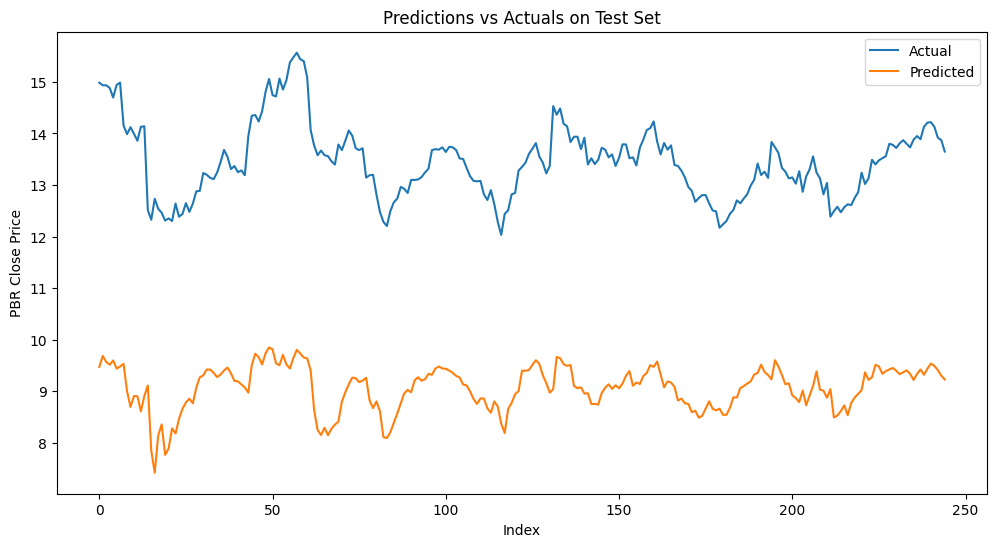

In [ ]:
# # Step 9: Denormalize and Visualize Predictions
# # Since we have multiple features, we need to only inverse transform the target variable
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

# # Denormalize the predictions and actuals
test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

# # Plot predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('PBR Close Price')
plt.legend()
plt.show()



In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Step 1: Load and Preprocess Data
# Load dataset
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)  # Last 5 years
df = yf.download('PBR', start=start_date, end=end_date)
df = df[['Close']]
df = df.sort_index()

# Step 2: Create Lag and Rolling Features
df['lag_5'] = df['Close'].shift(5)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_sd_10'] = df['Close'].rolling(window=10).std()
# df['rolling_diff_10'] = df['Close'] - df['rolling_mean_10']
df.dropna(inplace=True)

# Step 3: Normalize the Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Step 4: Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 5
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Step 6: Build the LSTM Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Last time step
        out = self.fc(out)
        return out


# Instantiate the LSTM model
model = LSTMModel(input_size=n_features, hidden_size=50, num_layers=1, output_size=1, dropout=0.2)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 150
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

# Step 8: Evaluate the Model
model.eval()
with torch.no_grad(): # this way prevents PyTorch from storing unnecessary information for backpropagation, making inference faster and more memory-efficient.
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/150, Train Loss: 0.000836, Valid Loss: 0.053189
Epoch 20/150, Train Loss: 0.000308, Valid Loss: 0.035034
Epoch 30/150, Train Loss: 0.000247, Valid Loss: 0.037947
Epoch 40/150, Train Loss: 0.000227, Valid Loss: 0.046682
Epoch 50/150, Train Loss: 0.000236, Valid Loss: 0.052801
Epoch 60/150, Train Loss: 0.000239, Valid Loss: 0.049559
Epoch 70/150, Train Loss: 0.000222, Valid Loss: 0.038893
Epoch 80/150, Train Loss: 0.000200, Valid Loss: 0.013339
Epoch 90/150, Train Loss: 0.000188, Valid Loss: 0.003339
Epoch 100/150, Train Loss: 0.000186, Valid Loss: 0.001667
Epoch 110/150, Train Loss: 0.000185, Valid Loss: 0.001973
Epoch 120/150, Train Loss: 0.000222, Valid Loss: 0.005924
Epoch 130/150, Train Loss: 0.000192, Valid Loss: 0.004984
Epoch 140/150, Train Loss: 0.000190, Valid Loss: 0.007403
Epoch 150/150, Train Loss: 0.000179, Valid Loss: 0.011213


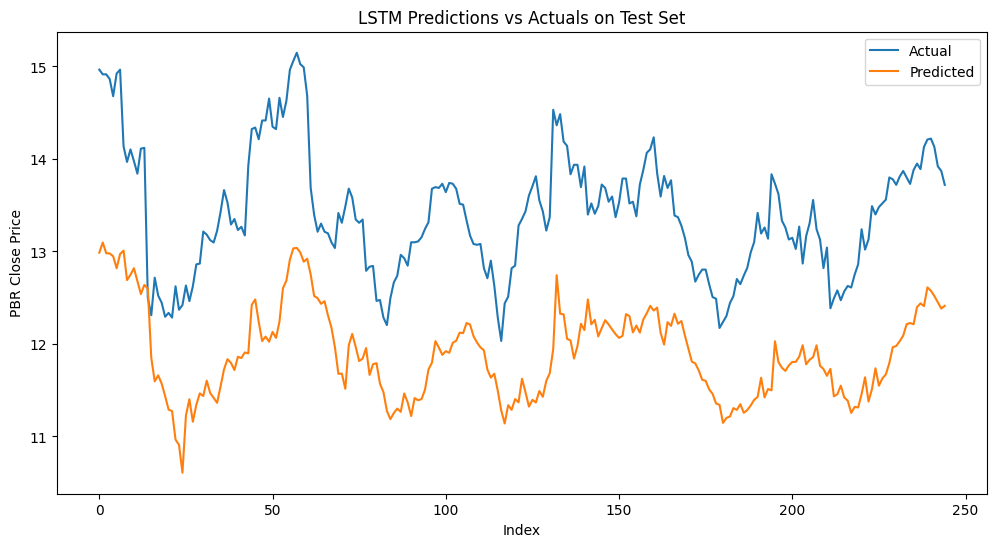

In [ ]:
# # Step 9: Denormalize and Visualize Predictions
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('LSTM Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('PBR Close Price')
plt.legend()
plt.show()

2 layers

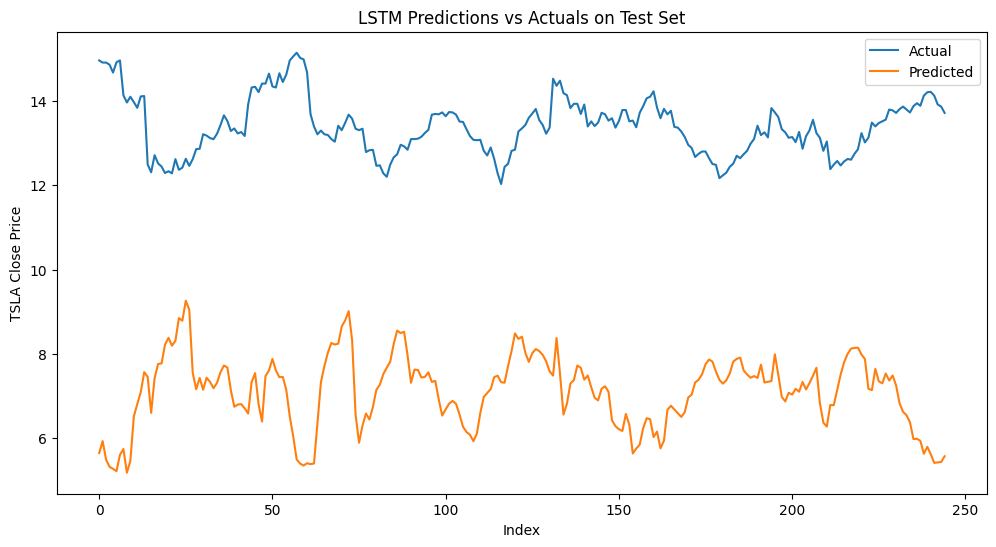

In [ ]:
# # Step 9: Denormalize and Visualize Predictions
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('LSTM Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

5 layer n_timesteps = 5

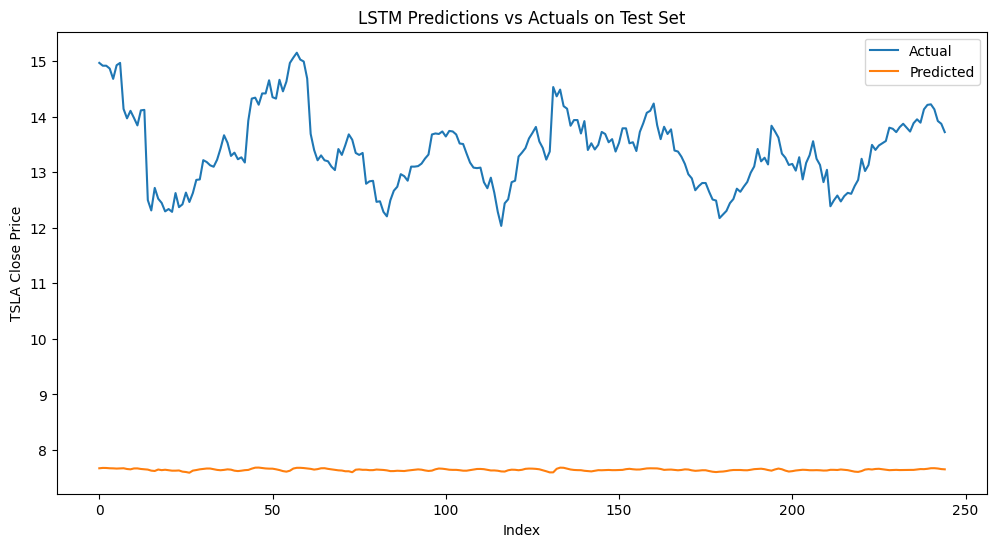

In [ ]:
# # Step 9: Denormalize and Visualize Predictions
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('LSTM Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

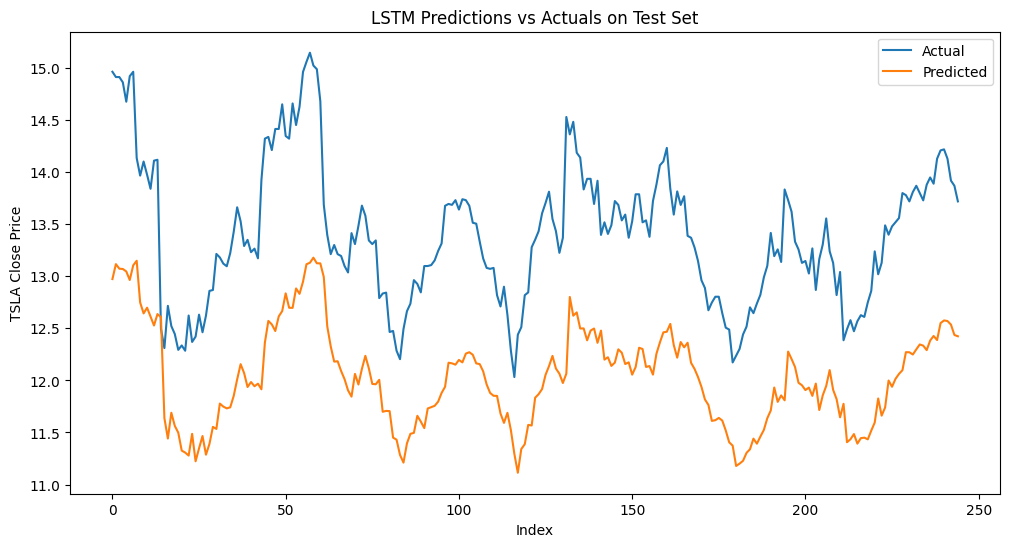

In [ ]:
# # Step 9: Denormalize and Visualize Predictions
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('LSTM Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()